In [11]:
import pandas as pd
import numpy as np
# import scanpy as sc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
import logging
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
# import np_utils
from tensorflow.keras.utils import to_categorical
# from openpyxl import Workbook
from sklearn.metrics import confusion_matrix
import umap
import tensorflow# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

tf.compat.v1.disable_eager_execution()

# modules:
from get_shap_evaluation import *
from get_intepretation import *

In [12]:
print("Get data")
random.seed(10)
mechanistic_model = pd.read_csv("Data.csv")
column_names = mechanistic_model.loc[:, mechanistic_model.columns != 'class'].columns
column_names = column_names[1:]
X = mechanistic_model.drop(mechanistic_model.columns[0],axis=1)


# In case you want to add Gaussian noise to a generated data
add_gausian_noise = True
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 
if add_gausian_noise:
    mu=0.0
    std = 0.2
    X = gaussian_noise(X,mu,std)

X = X.loc[:, X.columns != 'class']
X = (X - X.mean())/(X.std())
Y= mechanistic_model['class']
Y = Y.astype(str)
classes, counts = np.unique(Y, return_counts=True)

# Encode class values as integers
encoder1 = LabelEncoder()
encoder1.fit(Y)
encodedY = encoder1.transform(Y)
dummyY = to_categorical(encodedY)
dummyY=pd.DataFrame(dummyY, index=Y.index, columns=Y.unique())

Get data


In [ ]:
print("NN training")
n_inputs = X.shape[1]
X = np.asarray(X)
X_train, X_test, y_train, y_test = train_test_split(X, dummyY, test_size=0.20)

# build model:
Classifier_mech_noise = Sequential()
Classifier_mech_noise.add(Dense(500, input_shape=(1200,), activation='relu'))
Classifier_mech_noise.add(Dropout(0.1))
Classifier_mech_noise.add(Dense(250, activation='relu'))
Classifier_mech_noise.add(Dense(100, activation='relu'))
Classifier_mech_noise.add(Dense(80, activation='relu'))
Classifier_mech_noise.add(Dense(60, activation='relu'))
Classifier_mech_noise.add(Dropout(0.2))
Classifier_mech_noise.add(Dense(40, activation='relu')) 
Classifier_mech_noise.add(Dense(20, activation='relu'))


Classifier_mech_noise.add(Dense(9, activation='softmax'))
Classifier_mech_noise.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = Classifier_mech_noise.fit(X_train, y_train, epochs=100, batch_size=500, verbose=2, validation_data=(X_test,y_test))
plt.figure(figsize=(12,8))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate the classifier on the test set
yhat = Classifier_mech_noise.predict(X_test)
class_labels = np.argmax(yhat, axis=1)
y_test = np.argmax(np.array(y_test), axis=1)
cm = confusion_matrix(class_labels, y_test)
fig, ax= plt.subplots(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=["1","2","3","4","5","6","7","8","9"], yticklabels=["1","2","3","4","5","6","7","8","9"])
plt.savefig("Confusion_matrix_sergio.pdf" ,dpi = 500)
acc = np.sum(class_labels == y_test) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

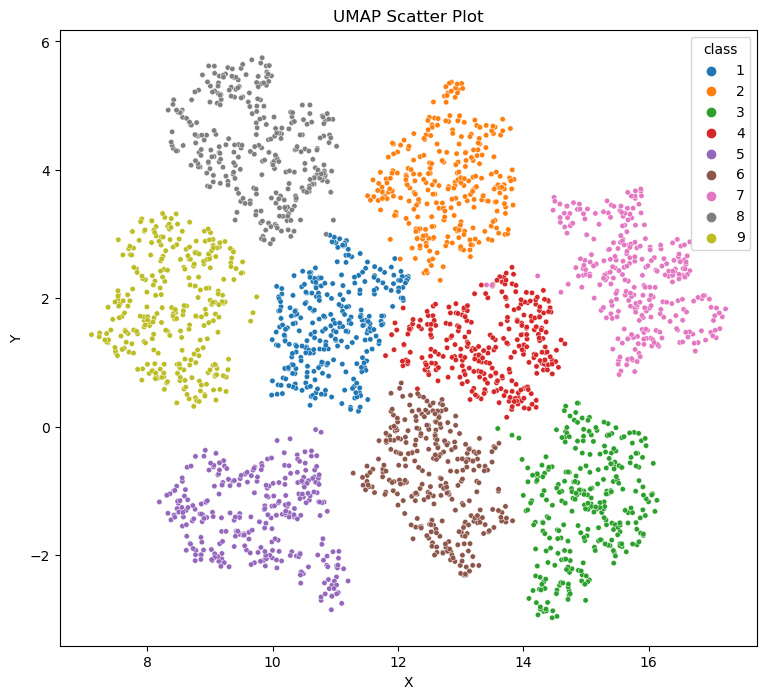

In [14]:
reducer = umap.UMAP(n_neighbors=200, min_dist=0.5)
embedding = reducer.fit_transform(X)
plt.figure(figsize=(9, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=Y, s=15, legend="full")
# Customize the plot as needed (e.g., add labels, titles, etc.)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('UMAP Scatter Plot')
# Display the plot
plt.show()

In [16]:
print("get_most_important_genes function")
def get_most_important_genes(
                             shap_values,
                             background,
                             shap_method,
                             X_test,
                             Y,
                             column_names,
                             master_regulators,
                             number_of_genes_to_check = 500
                             ):
    '''
    Find most important genes based on the shap values
    '''
    deep_shap_dict_all = {key: None for key in np.unique(Y)}
    
    number_of_classes = len(np.unique(Y))
    
    #get most important features from last part:
    for i in range(0,number_of_classes):
        
        vals = np.abs(shap_values[i]).mean(0)
        feature_importance = pd.DataFrame(list(zip(column_names, vals)), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
        deep_shap_class = feature_importance[:]
        deep_shap_dict_all[np.unique(Y)[i]] = deep_shap_class[:]
        
    output = open('shap_genes_normal_{}.pkl'.format(shap_method), 'wb')
    pickle.dump(deep_shap_dict_all, output)
    output.close()
    return deep_shap_dict_all, feature_importance, shap_values

get_most_important_genes function


In [17]:
print("get shap val function")
def get_shap_values(
                    Classifier,
                    background,
                    X_test,
                    Y,
                    column_names,
                    master_regulators,
                    shap_method = ['Deep', 'Kern', 'Gradiant'],
                    number_of_genes_to_check = 500
                    ):
    '''
    Gets shap values based on method and background
    outputs: shap plots and feature importances
    '''
    
    deep_shap_dict_all_all_methods = []
    common_w_master_regulators_percent_all_dshap_all_methods = []
    
    shap_values_all_methods = []
    feature_importance_all_methods = []
    
    for method in shap_method:
        if  method =='Deep':
            e = shap.DeepExplainer(Classifier, background)
        elif method == 'Kern':
            e =  shap.KernelExplainer(Classifier.predict, background)
        elif method == 'Gradiant':
            e = shap.GradientExplainer(Classifier, background)

        # get just the explanations for the positive class
        shap_values = e.shap_values(X_test)
        shap.summary_plot(shap_values[0], X_test, plot_type = 'dot', feature_names =column_names, show=False)
        ax = plt.gca()
        ax.legend(fontsize='large')
        plt.savefig("shap_normal_dot_{}.pdf".format(method), bbox_inches='tight', dpi=300)
        shap.summary_plot(shap_values[0], plot_type='bar', feature_names=column_names, show=False)
        ax = plt.gca()
        ax.legend(fontsize='large')
        plt.savefig("shap_normal_bar_{}.pdf".format(method), bbox_inches='tight', dpi=300)
        plt.show()       
        shap.summary_plot(shap_values,X_test,feature_names=column_names)
        
        # get most important genes based on shap values:
        deep_shap_dict_all, feature_importance, shap_values = get_most_important_genes( 
                        
                                     shap_values,
                                     background,
                                     method,
                                     X_test,
                                     Y,
                                     column_names,
                                     master_regulators,
                                     number_of_genes_to_check = number_of_genes_to_check
                                     
                                     )
        
        deep_shap_dict_all_all_methods.append(deep_shap_dict_all)        
        shap_values_all_methods.append(shap_values)
        feature_importance_all_methods.append(feature_importance)
    
    return deep_shap_dict_all_all_methods, feature_importance_all_methods, shap_values_all_methods

get shap val function


In [ ]:
# list of predefined master regulators:
master_regulators = ["Gene 82", "Gene 107", "Gene 584", "Gene 449", "Gene 485", "Gene 566", "Gene 1141", "Gene 1076", "Gene 188", "Gene 80", "Gene 703", "Gene 939","Gene 756", "Gene 504", "Gene 992", "Gene 559", "Gene 1085", "Gene 121",
    "Gene 1007", "Gene 888", "Gene 231", "Gene 542", "Gene 255", "Gene 251","Gene 242", "Gene 4", "Gene 866", "Gene 1177", "Gene 957", "Gene 713","Gene 949", "Gene 1069", "Gene 407", "Gene 1", "Gene 109", "Gene 685","Gene 1122", "Gene 1038", "Gene 1088", "Gene 961", "Gene 240", "Gene 783",
    "Gene 1145", "Gene 110", "Gene 1046", "Gene 1005", "Gene 64", "Gene 581", "Gene 96", "Gene 804", "Gene 450", "Gene 475", "Gene 543", "Gene 1012","Gene 1105", "Gene 1148", "Gene 1020", "Gene 956", "Gene 442", "Gene 719", "Gene 875", "Gene 1031", "Gene 1033", "Gene 1077", "Gene 134", "Gene 731"]

number_of_genes_to_check = 500
background = X_train[np.random.choice(pd.DataFrame(X_train).index, 500, replace=False)]

print("get shap values std")
[most_important_shap_features_all_std,
feature_importance_all_methods_std,
shap_values_all_methods_std] = get_shap_values(
                    Classifier_mech_noise,
                    background,
                    X_test,
                    Y,
                    column_names,
                    master_regulators,
                    shap_method = ['Deep', 'Gradiant', 'Kern'],
                    number_of_genes_to_check = number_of_genes_to_check
                    )

In [ ]:
print("Act_max function adv")
def my_activation_maximization(myModel, class_idx):    

    input_vec = myModel.input
    output_vec = myModel.output[:,class_idx]
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(myModel.output[:,class_idx]) 
        
    # Compute the gradient of the loss w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(loss, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Start gradient ascent from a random input vector:
    rand_vec = np.random.random((1, input_vec.shape[1]))
    
    # Gradient ascent:
    alpha = 0.1
    num_steps = 5
    for i in range(num_steps):
        loss_value, grads_value = iterate([rand_vec])
        rand_vec += grads_value*1.
        
    rand_vec = np.transpose(rand_vec)
    
    return rand_vec

def get_top_genes_all_cells_am(act_max,
                           n = 20):
    '''
    based on AM find the most important genes of each group
    '''

    
    cell_types = act_max.columns[1:]
    top_genes = pd.DataFrame( columns = cell_types )
    act_max_abs = abs(act_max.iloc[:,1:])
    act_max_abs.insert(0,'Gene',act_max.iloc[:,0] )

    for cell_type in cell_types:
        top_genes.loc[:,cell_type] = act_max_abs.sort_values(cell_type, ascending=False).reset_index().Gene[:n]
    return top_genes

In [ ]:
print("AM std")
genes = column_names[:] #.str.extract('(\d+)').astype(int)
act_max_std =  pd.DataFrame(genes.values, columns=['Gene'])

# Computing activation maximization for each class:
class_idx = 0
for class_label in np.unique(Y): 
    print(class_label)
    
    act_max_std[class_label] = my_activation_maximization(Classifier_mech_noise, class_idx)        
    class_idx+=1

# Get the most important genes from activation maximization:
feature_importance_am_std = get_top_genes_all_cells_am(act_max_std, n = number_of_genes_to_check)

In [ ]:
import multiprocessing
def my_saliency_map(Mymodel,class_idx, sample_vec):    
    input_vec = Mymodel.input
    output_vec = Mymodel.output[:, class_idx]    
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(Mymodel.output[:, class_idx])  
 
    # Compute the gradient of the output vector w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(output_vec, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Gradient descent on the given sample_vec:
    alpha = 0.1
    num_steps = 1
    
    sample_vec = sample_vec.reshape(1,n_inputs)
    for i in range(num_steps):
        loss_value, grads_value = iterate([sample_vec])
        grads_value -= grads_value*alpha
    
    return grads_value[0]

# Create dataframes of gene expression and saliency maps of size num_genes X num_samples:
genes = mechanistic_model.columns.values.tolist()
expression_all_samples =  pd.DataFrame(genes, columns=['Gene'])
saliency_all_samples =  pd.DataFrame(genes, columns=['Gene'])
# Create a dataframe of averaged saliency maps of size num_genes X num_classes:
saliency_average_samples = pd.DataFrame(genes, columns=['Gene'])

x_train = X
class_idx=0
for class_label in np.unique(Y): 
    #print(class_label)
    i=0
    class_samples_indices = np.where(encodedY==class_idx)[0]
    np.random.shuffle(class_samples_indices)   
    num_class_samples = len(class_samples_indices)
    #print(num_class_samples)
    
    class_expression = pd.DataFrame(np.zeros((n_inputs, num_class_samples)),columns=[str(class_label) + '_' + str(x) for x in range(num_class_samples)])
    class_saliency = pd.DataFrame(np.zeros((n_inputs, num_class_samples)),columns=[str(class_label) + '_' + str(x) for x in range(num_class_samples)])
    
    for sample_idx in class_samples_indices:       
        sample_vec = x_train[:][sample_idx]
        class_expression.iloc[:,i] = sample_vec
        # pool = multiprocessing.Pool()
        # l=((class_idx,sample_vec))
        # saliency_vec = pool.map(my_saliency_map, l)
        saliency_vec = my_saliency_map(Classifier_mech_noise, class_idx, sample_vec)
        class_saliency.iloc[:,i] = saliency_vec
        i+=1
        #print(i)
    
    expression_all_samples = expression_all_samples.join(class_expression)
    saliency_all_samples = saliency_all_samples.join(class_saliency)
    saliency_average_samples[class_label] = np.mean(class_saliency,axis=1)
    class_saliency = saliency_all_samples['Gene'].to_frame().join(class_saliency)   
    class_idx+=1

In [ ]:
# Lime Method:
print("Lime std")

import lime
import lime.lime_tabular
import time
start = time.time()

e_lime = lime.lime_tabular.LimeTabularExplainer(
                            X_train, feature_names=column_names, 
                            class_names=Y.unique(), discretize_continuous=True
                            )

# get the most important genes based on Lime
lime_important_features_all_all_std = []
lime_important_features_all_all_genes_std = []
for i in range(len(np.unique(Y))):
    
    # find all the test samples of each class:
    important_features_class_all_std = []
    class_indx = np.where(y_test == i)
    X_test_class = X_test[class_indx]

    # get all important genes using lime for each test sample of the class:
    for j in range(len(X_test_class)):
        exp_std = e_lime.explain_instance(X_test_class[j], Classifier_mech_noise.predict, num_features=len(column_names[:]),
                                      top_labels=number_of_genes_to_check, num_samples=500)
        '''
        Make num_sample = 100 or more
        '''
        print("j:",j)
        outputs = exp_std.as_map()
        for k in range(number_of_genes_to_check):
            important_features_class_all_std.append(outputs[i][k][0])

    # find the most repeated genes of the specific class:
    count_repeats_class_std = dict((i, important_features_class_all_std.count(i)) for i in important_features_class_all_std)
    count_repeats_class_std = sorted(count_repeats_class_std.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]
    
    # select the most repeated ones:
    count_repeats_class_top_std = []
    for m in range(number_of_genes_to_check):
        count_repeats_class_top_std.append(count_repeats_class_std[m][0])

    # append for each class:
    lime_important_features_all_all_std.append(count_repeats_class_top_std)

# Change index to gene names:
for m in range(len(lime_important_features_all_all_std)):
    lime_important_features_all_all_genes_std.append(list((column_names[lime_important_features_all_all_std[m]])))
    
end = time.time()
print(end - start)    


In [25]:
print("majorit vote std")

shap_method =  ['Deep', 'Gradiant', 'Kern']

all_methods_all_important_genes_std = []

ys = np.unique(Y)
get_imp_genes_method_std = []

for j in range(len(np.unique(Y))):
    # shap methods:
    get_imp_genes_method_std = []

    for i in range(len(shap_method)):
        get_imp_genes_method_std = get_imp_genes_method_std + list(most_important_shap_features_all_std[i][ys[j]][:number_of_genes_to_check].col_name.values)
    
    # activation maximization:
    get_imp_genes_method_std = get_imp_genes_method_std + list(feature_importance_am_std.iloc[:,j].values)

    # Saliency map:
    get_imp_genes_method_std = get_imp_genes_method_std + list(class_saliency.iloc[:,j].values)

    
    # lime:
    get_imp_genes_method_std = get_imp_genes_method_std + lime_important_features_all_all_genes_std[j]



    
    all_methods_all_important_genes_std.append(get_imp_genes_method_std)


# calcualte the most repeated genes for each group:
count_repeats_all_all_std = []
for j in range(len(np.unique(Y))):

    count_repeats_all_std = dict((i, all_methods_all_important_genes_std[j].count(i)) for i in all_methods_all_important_genes_std[j])
    count_repeats_all_std = sorted(count_repeats_all_std.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]

    #for m in range(number_of_genes_to_check):
    #    count_repeats_all_class.append(count_repeats_all[m][0])
    count_repeats_all_all_std.append(count_repeats_all_std)




majorit vote std


<h1>Adversarial training<h1>

In [27]:
print("adv training function")
def adversarial_training(Classifier_mech_noise,
                         X_test,
                         y_train,
                         y_test,
                         X_train,
                         epsilon = 1,  # Maximum perturbation
                         attack_type = 'FGSM'
                         ):
    
    '''
    Adversarial training using FGSM
    '''
    
    ant_art = KerasClassifier(model=Classifier_mech_noise)
    if attack_type == 'FGSM':
        print("Adversarial Training with FGSM:\n")
        adv_crafter = FastGradientMethod(ant_art, eps=epsilon)
    elif attack_type == 'PGD':
        print("Adversarial Training with PGD:\n")
        adv_crafter = ProjectedGradientDescent(ant_art, eps= epsilon)

    x_test_adv = adv_crafter.generate(x=np.array(X_test))
    x_train_adv = adv_crafter.generate(x=np.array(X_train))
    
    
    # Evaluate the classifier on the adversarial examples
    preds = np.argmax(ant_art.predict(x_test_adv), axis=1)
    acc_adv = np.sum(preds == y_test) / y_test.shape[0]
    print("\nTest accuracy on adversarial sample: %.2f%%" % (acc_adv * 100))
    
    
    #update input:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter("[%(levelname)s] %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    #updated input:
    x_train_adv = np.append(X_train, x_train_adv, axis=0)
    y_train_adv = np.append(y_train, y_train, axis=0)
    
    
    #retrain model:
    history = Classifier_mech_noise.fit(x_train_adv, y_train_adv, epochs=100, batch_size=500)

    # Evaluate the adversarially trained classifier on the test set
    preds = np.argmax(Classifier_mech_noise.predict(x_test_adv), axis=1)
    acc = np.sum(preds == y_test) / y_test.shape[0]
    logger.info("Classifier with adversarial training")
    logger.info("Accuracy on adversarial samples: %.2f%%", (acc * 100))
    
    return Classifier_mech_noise, x_train_adv, y_train_adv, x_test_adv

adv training function


In [ ]:
# Impelementing Adversarial Training:
# attack_type options: 'PGD', 'FGSM'
print("adv training")
Classifier_mech_noise_adv, x_train_adv, y_train_adv, x_test_adv = adversarial_training(Classifier_mech_noise,
                            X_test,
                            y_train,
                            y_test,
                            X_train,
                            epsilon = 1.5, # Maximum perturbation
                            attack_type = 'FGSM'
                            )

preds2 = np.argmax(y_train_adv, axis=1)
reducer = umap.UMAP(n_neighbors=500, min_dist= 0.9)
# embedding = reducer.fit_transform(X)
embedding = reducer.fit_transform(x_train_adv)
embedding=pd.DataFrame(embedding)
plt.figure(figsize=(9, 8))
g=sns.scatterplot(data=embedding, x=0, y=1, hue=preds2, s=15, legend="full", palette="Set1")

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("UMAP of adversarial Training")

In [ ]:
print("shap values adv")
number_of_genes_to_check = 500
background = X_train[np.random.choice(pd.DataFrame(X_train).index, 500, replace=False)]


[most_important_shap_features_all_adv,
feature_importance_all_methods_adv,
shap_values_all_methods_adv] = get_shap_values(
                    Classifier_mech_noise_adv,
                    background,
                    X_test,
                    Y,
                    column_names,
                    master_regulators,
                    shap_method = ['Deep','Gradiant','kern'],
                    number_of_genes_to_check = number_of_genes_to_check
                    )


In [ ]:
# Create a dataframe of activation maximization scores of size num_genes X num_classes:
print("Act max adv")

genes = column_names[:] #.str.extract('(\d+)').astype(int)
act_max_adv =  pd.DataFrame(genes.values, columns=['Gene'])

# Computing activation maximization for each class:
class_idx = 0
for class_label in np.unique(Y): 
    print(class_label)
    
    act_max_adv[class_label] = my_activation_maximization(Classifier_mech_noise_adv, class_idx)        
    class_idx+=1

# Get most important genes from activation maximization:
feature_importance_am_adv = get_top_genes_all_cells_am(act_max_adv,
                           n = number_of_genes_to_check)

In [ ]:
# Lime Method:
print("Lime adv")

import lime
import lime.lime_tabular
import time
start = time.time()

e_lime = lime.lime_tabular.LimeTabularExplainer(
                            x_train_adv, feature_names=column_names, 
                            class_names=Y.unique(), discretize_continuous=True
                            )

# get most important genes based on Lime
# find local important genes for each class and aggregate over all of them

lime_important_features_all_all_adv = []
lime_important_features_all_all_genes_adv = []
for i in range(len(np.unique(Y))):
    
    # find all the test samples of each class:
    important_features_class_all_adv = []
    class_indx = np.where(y_test == i)
    X_test_class = X_test[class_indx]

    # get all important genes using lime for each test sample of the class:
    for j in range(len(X_test_class)):
        # double check this part with top_labels and num_features ** change number of samples too **
        exp = e_lime.explain_instance(X_test_class[j], Classifier_mech_noise_adv.predict, num_features=len(column_names[:]),
                                      top_labels=number_of_genes_to_check, num_samples=500)
        '''
        Make num_sample = 100 or more
        '''
        print("j:",j)
        outputs = exp.as_map()
        for k in range(number_of_genes_to_check):
            important_features_class_all_adv.append(outputs[i][k][0])

    # find most repeates genes of the specific class:
    count_repeats_class_adv = dict((i, important_features_class_all_adv.count(i)) for i in important_features_class_all_adv)
    count_repeats_class_adv = sorted(count_repeats_class_adv.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]
    
    # select the most repeated ones:
    count_repeats_class_top_adv = []
    for m in range(number_of_genes_to_check):
        count_repeats_class_top_adv.append(count_repeats_class_adv[m][0])

    # append for each class:
    lime_important_features_all_all_adv.append(count_repeats_class_top_adv)

# change index to gene names:
for m in range(len(lime_important_features_all_all_adv)):
    lime_important_features_all_all_genes_adv.append(list((column_names[lime_important_features_all_all_adv[m]])))
    
end = time.time()
print(end - start)    
    

In [ ]:
# get majority vote:
print("Majority vote_adv")

shap_method = ['Deep','Gradiant','kern']

all_methods_all_important_genes_adv = []

ys = np.unique(Y)

for j in range(len(np.unique(Y))):
    get_imp_genes_method_adv = []
    # shap methods:
    for i in range(len(shap_method)):
        get_imp_genes_method_adv = get_imp_genes_method_adv + list(most_important_shap_features_all_adv[i][ys[j]][:number_of_genes_to_check].col_name.values)
    

    # activation maximization:
    get_imp_genes_method_adv = get_imp_genes_method_adv + list(feature_importance_am_adv.iloc[:,j].values)


    # lime:
    get_imp_genes_method_adv = get_imp_genes_method_adv + lime_important_features_all_all_genes_adv[j]
    
    all_methods_all_important_genes_adv.append(get_imp_genes_method_adv)

# calcualte the most repeated genes for each group:
count_repeats_all_all_adv = []
for j in range(len(np.unique(Y))):
    count_repeats_all_adv = dict((i, all_methods_all_important_genes_adv[j].count(i)) for i in all_methods_all_important_genes_adv[j])
    count_repeats_all_adv = sorted(count_repeats_all_adv.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]

    #for m in range(number_of_genes_to_check):
    #    count_repeats_all_class.append(count_repeats_all[m][0])
    count_repeats_all_all_adv.append(count_repeats_all_adv)

In [39]:
def plot(adv,std,methody):
    cell_types = np.unique(Y)
    defense_frame = pd.DataFrame(columns = ['Cell_Type', 'Common_Genes', "Method"])
    defense_frame["Cell_Type"] = cell_types
    defense_frame["Method"]  = "Adv-Training"
    defense_frame["Common_Genes"] = adv
    

    defense_frame_1 = pd.DataFrame(columns = ['Cell_Type', 'Common_Genes', "Method"])
    defense_frame_1["Cell_Type"] = cell_types
    defense_frame_1["Method"]  = "Std-Training"
    defense_frame_1["Common_Genes"] = std
    
    defense_all_dataframe = pd.concat([defense_frame_1,defense_frame]).reset_index().drop('index',axis=1)
    
    
    plt.figure(figsize = (40, 25))
    g = sns.catplot(
        data=defense_all_dataframe, kind="bar",
        x="Cell_Type", y="Common_Genes", hue="Method",
        errorbar="sd", palette="bright", alpha=.8, height=6)
    
    g.despine(left=True)
    g.set_axis_labels("Cell Types", "Detected Genes")
    g.legend.set_title("Type of Traning")
    # plt.yticks(np.arange(0, 22, 2.0))

plt.show()

[15, 17, 16, 13, 15, 18, 10, 13, 15]
[8, 27, 25, 12, 19, 17, 10, 15, 25]


<Figure size 4000x2500 with 0 Axes>

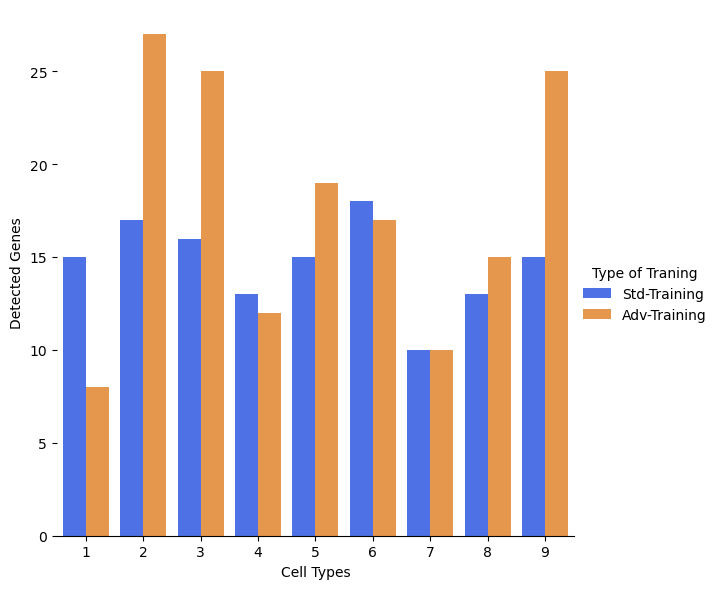

In [40]:
common_w_master_regulators_percent_all_dshap_DEEP_std = []
# compare detected master regulators
for i in range(1,10):
    check_genes_DEEP_std = most_important_shap_features_all_std[0][str(i)]
    check_genes_DEEP_std = [j for j in check_genes_DEEP_std.iloc[:,0]]
    check_genes_DEEP_std = check_genes_DEEP_std[:number_of_genes_to_check]

    common_w_master_regulators_DEEP_std = list(set(master_regulators).intersection(check_genes_DEEP_std[:]))
    common_w_master_regulators_percent_DEEP_std = len(common_w_master_regulators_DEEP_std) #/len(master_regulators)     
    common_w_master_regulators_percent_all_dshap_DEEP_std.append(common_w_master_regulators_percent_DEEP_std)   
    
print(common_w_master_regulators_percent_all_dshap_DEEP_std)

##############################

common_w_master_regulators_percent_all_dshap_DEEP_adv = []
# compare detected master regulators
for i in range(1,10):
    check_genes_DEEP_adv = most_important_shap_features_all_adv[0][str(i)]
    check_genes_DEEP_adv = [j for j in check_genes_DEEP_adv.iloc[:,0]]
    check_genes_DEEP_adv = check_genes_DEEP_adv[:number_of_genes_to_check]

    common_w_master_regulators_DEEP_adv = list(set(master_regulators).intersection(check_genes_DEEP_adv[:]))
    common_w_master_regulators_percent_DEEP_adv = len(common_w_master_regulators_DEEP_adv) #/len(master_regulators)     
    common_w_master_regulators_percent_all_dshap_DEEP_adv.append(common_w_master_regulators_percent_DEEP_adv)   
    
print(common_w_master_regulators_percent_all_dshap_DEEP_adv)



plot(common_w_master_regulators_percent_all_dshap_DEEP_adv, common_w_master_regulators_percent_all_dshap_DEEP_std,"DEEP")